## Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
%matplotlib inline
# %load_ext nb_black


## DF loading

In [2]:
initial_df = pd.read_csv("insurance.csv")
initial_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Data analysis

In [3]:
# initial_df.info()


In [4]:
# profile = ProfileReport(initial_df)
# profile

In [5]:
# sns.pairplot(initial_df)
# plt.show()


### one hot encoding

In [6]:
# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

In [7]:
# sprawdzenie
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
0,19,27.900,0,16884.92400,0,1,0,0,1,0,0
1,18,33.770,1,1725.55230,1,0,0,1,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0,1,0
1334,18,31.920,0,2205.98080,0,0,0,0,0,1,0
1335,18,36.850,0,1629.83350,0,0,0,1,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1,0,0


In [8]:
# Function to calculate VIF
import statsmodels.api as sm

def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X_vif=df.drop(['charges'],axis=1)
calculate_vif(X_vif)

,Var,Vif
1,bmi,18.38
0,age,8.25
8,obese,4.13
9,obese_smoker,2.66
2,children,1.82
6,region_southeast,0.68
3,sex_male,0.49
7,region_southwest,0.42
5,region_northwest,0.41
4,smoker_yes,0.17


In [9]:
# # nowa mapa korelacji
# corr = np.corrcoef(np.random.randn(11, 200))
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
# plt.figure(figsize=(12, 12))
# sns.heatmap(df.corr(), cmap="YlGnBu", mask=mask, square=True)

## Train, test split

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop("charges", axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.3, random_state=42, stratify=X.smoker_yes)

y_test.shape

(402,)

### Pipeline, Scaler

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [12]:
s_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
r_scaler = RobustScaler()

### PCA & Pipeline import

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full', n_components=0.95, random_state=42)

### CV, GridSearchCV import

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### Metrics import

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from math import sqrt

### Model test function

In [16]:
def model_test(pipeline, Xtrain, ytrain, Xtest, ytest):
    pipeline.fit(Xtrain, ytrain)
    y_pred_train = pipeline.predict(Xtrain)
    y_pred_test = pipeline.predict(Xtest)
    
    print('Zbiór treningowy:')
    print(f'R^2 dla {pipeline}: \n {pipeline.score(Xtrain, ytrain)}')
    print(f'MSE {pipeline}: \n {mean_squared_error(ytrain, y_pred_train)}')
    print(f'RMSE {pipeline}: \n {sqrt(mean_squared_error(ytrain, y_pred_train))}')
    print(f'MAE {pipeline}: \n {mean_absolute_error(ytrain, y_pred_train)}')
    print('\n ------------ \n')
    print('Zbiór testowy:')
    print(f'R^2 dla {pipeline}: \n {pipeline.score(Xtest, ytest)}')
    print(f'MSE {pipeline}: \n {mean_squared_error(ytest, y_pred_test)}')
    print(f'RMSE {pipeline}: \n {sqrt(mean_squared_error(ytest, y_pred_test))}')
    print(f'MAE {pipeline} : \n {mean_absolute_error(ytest, y_pred_test)}')
    
    print('\n ------------ \n')
    print(f'cross validation for {pipeline}: {cross_val_score(pipeline, Xtrain, ytrain, cv=5).mean()} \n')
    
    x_ax = range(len(y_test))
    plt.scatter(x_ax, ytest, label="original")
    plt.scatter(x_ax, y_pred_test, label="predicted")
    plt.title("Test and predicted data")
    plt.legend()
    plt.show()
    
    return pipeline.fit(Xtrain, ytrain)

## Lasso for feature selection

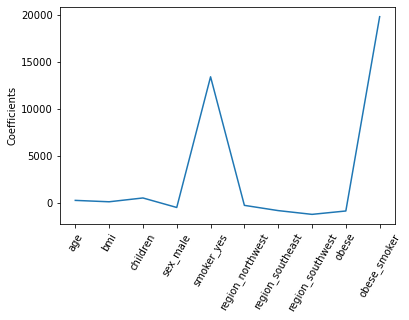

In [17]:
from sklearn.linear_model import Lasso

names = X.columns
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_

_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

## Lasso regression

##### Lasso standard (X_train, y_train)

In [18]:
lasso_std = Lasso()

pipeline_lasso_1 = make_pipeline(lasso_std)

Zbiór treningowy:
R^2 dla Pipeline(steps=[('lasso', Lasso())]): 
 0.8604653597150158
MSE Pipeline(steps=[('lasso', Lasso())]): 
 20437414.57208261
RMSE Pipeline(steps=[('lasso', Lasso())]): 
 4520.775881647155
MAE Pipeline(steps=[('lasso', Lasso())]): 
 2534.609245748564

 ------------ 

Zbiór testowy:
R^2 dla Pipeline(steps=[('lasso', Lasso())]): 
 0.8710886882825442
MSE Pipeline(steps=[('lasso', Lasso())]): 
 18901531.860295907
RMSE Pipeline(steps=[('lasso', Lasso())]): 
 4347.589200959068
MAE Pipeline(steps=[('lasso', Lasso())]) : 
 2421.1396966094376

 ------------ 

cross validation for Pipeline(steps=[('lasso', Lasso())]): 0.8517248803506355 



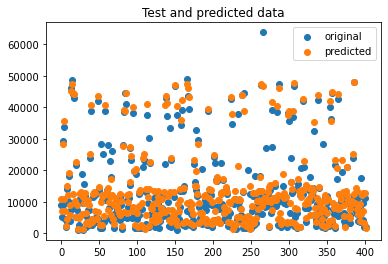

Pipeline(steps=[('lasso', Lasso())])

In [19]:
model_test(pipeline_lasso_1, X_train, y_train, X_test, y_test)

Zbiór treningowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 0.8604657743978603
MSE Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 20437353.834152646
RMSE Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 4520.76916399772
MAE Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 2534.5121887922855

 ------------ 

Zbiór testowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 0.8710847864580685
MSE Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 18902103.962609176
RMSE Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 
 4347.654995812016
MAE Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]) : 
 2420.8135715648

 ------------ 

cross validation for Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())]): 0.8517195190423461 



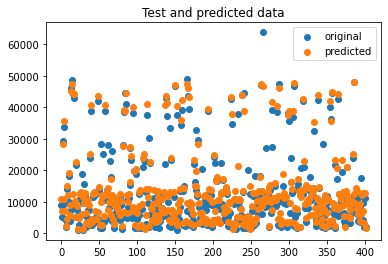

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [20]:
pipeline_lasso_2 = make_pipeline(s_scaler, lasso_std)

model_test(pipeline_lasso_2, X_train, y_train, X_test, y_test)

Zbiór treningowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 0.8585085360235932
MSE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 20724027.394134503
RMSE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 4552.365033049799
MAE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 2552.506917468527

 ------------ 

Zbiór testowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()),
         

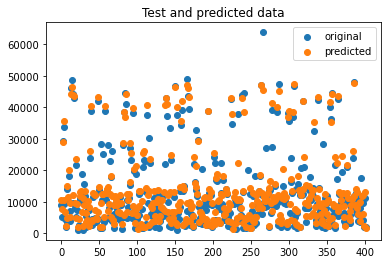

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())])

In [21]:
pipeline_lasso_3 = make_pipeline(s_scaler, pca, lasso_std)

model_test(pipeline_lasso_3, X_train, y_train, X_test, y_test)

Zbiór treningowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 0.8585085360235932
MSE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 20724027.394134503
RMSE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 4552.365033049799
MAE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('lasso', Lasso())]): 
 2552.506917468527

 ------------ 

Zbiór testowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()),
         

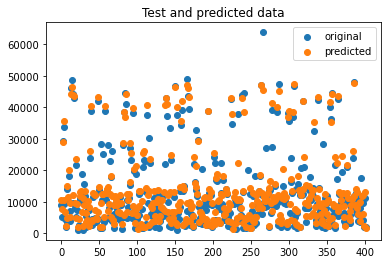

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('pca', PCA(n_components=0.95, random_state=42, svd_solver='full')),
  ('lasso', Lasso())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'pca': PCA(n_components=0.95, random_state=42, svd_solver='full'),
 'lasso': Lasso(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 0.95,
 'pca__random_state': 42,
 'pca__svd_solver': 'full',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': 'deprecated',
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': None,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [22]:
model_test(pipeline_lasso_3, X_train, y_train, X_test, y_test).get_params(deep=True)

### RandomizedSearchCV Lasso regression

In [23]:
pipeline_lasso_gs_1 = make_pipeline(s_scaler, pca, lasso_std)

# Specify the hyperparameter space
parameters = {'lasso__alpha':np.linspace(0,100,500),
             'lasso__fit_intercept':[True, False],
             'lasso__warm_start':[True, False],
             'lasso__positive':[True, False],
             'lasso__selection': ['cyclic', 'random'],
             'lasso__max_iter':np.linspace(100,2000,100)}

# Create the GridSearchCV object
lasso_cv = RandomizedSearchCV(pipeline_lasso_gs_1, 
                              param_distributions=parameters, cv=3)

# Fit to the training set
lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv.predict(X_test)

# Compute and print the metrics
score = lasso_cv.score(X_test, y_test)
print("Tuned Lasso Alpha: {} \n".format(lasso_cv.best_params_))
print('Best params score: {} \n'.format(lasso_cv.best_score_))
print("Tuned Lasso score: {} \n".format(score))
print(f'Tuned Lasso MSE: {mean_squared_error(y_test, y_pred_lasso_cv)} \n')
print(f'Tuned Lasso RMSE: {sqrt(mean_squared_error(y_test, y_pred_lasso_cv))} \n')
print(f'Tuned Lasso MAE: {mean_absolute_error(y_test, y_pred_lasso_cv)} \n')

Tuned Lasso Alpha: {'lasso__warm_start': True, 'lasso__selection': 'cyclic', 'lasso__positive': False, 'lasso__max_iter': 714.1414141414141, 'lasso__fit_intercept': True, 'lasso__alpha': 6.212424849699399} 

Best params score: 0.8523035842708496 

Tuned Lasso score: 0.8687400948689088 

Tuned Lasso MSE: 19245892.74409489 

Tuned Lasso RMSE: 4387.014103475722 

Tuned Lasso MAE: 2442.7045209588036 



## Ridge regression

In [24]:
from sklearn.linear_model import Ridge

ridge_std = Ridge()

Zbiór treningowy:
R^2 dla Pipeline(steps=[('ridge', Ridge())]): 
 0.8604253705396929
MSE Pipeline(steps=[('ridge', Ridge())]): 
 20443271.722341485
RMSE Pipeline(steps=[('ridge', Ridge())]): 
 4521.423638893118
MAE Pipeline(steps=[('ridge', Ridge())]): 
 2539.0863816271676

 ------------ 

Zbiór testowy:
R^2 dla Pipeline(steps=[('ridge', Ridge())]): 
 0.8712125654141842
MSE Pipeline(steps=[('ridge', Ridge())]): 
 18883368.461605277
RMSE Pipeline(steps=[('ridge', Ridge())]): 
 4345.499794224512
MAE Pipeline(steps=[('ridge', Ridge())]) : 
 2424.1666345581903

 ------------ 

cross validation for Pipeline(steps=[('ridge', Ridge())]): 0.8517178296326483 



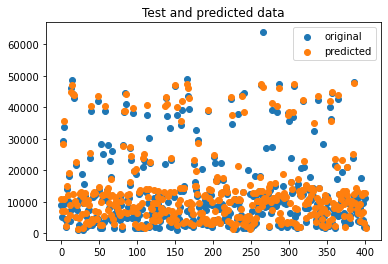

Pipeline(steps=[('ridge', Ridge())])

In [28]:
pipeline_ridge_2 = make_pipeline(ridge_std)

model_test(pipeline_ridge_2, X_train, y_train, X_test, y_test)

Zbiór treningowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('ridge', Ridge())]): 
 0.8585081402522512
MSE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('ridge', Ridge())]): 
 20724085.36212708
RMSE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('ridge', Ridge())]): 
 4552.371399845039
MAE Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('ridge', Ridge())]): 
 2553.4376301757347

 ------------ 

Zbiór testowy:
R^2 dla Pipeline(steps=[('standardscaler', StandardScaler()),
         

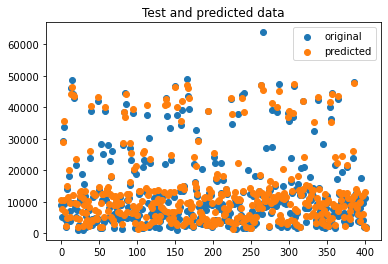

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca',
                 PCA(n_components=0.95, random_state=42, svd_solver='full')),
                ('ridge', Ridge())])

In [26]:
pipeline_ridge_3 = make_pipeline(s_scaler, pca, ridge_std)

model_test(pipeline_ridge_3, X_train, y_train, X_test, y_test)

### RandomizedSearchCV Ridge regression

In [27]:
pipeline_ridge_gs_1 = make_pipeline(s_scaler, ridge_std)

# Specify the hyperparameter space
parameters_ridge = {'ridge__alpha':np.linspace(0.1,50,50),
              'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
             'ridge__positive':[True, False],
             'ridge__max_iter':np.linspace(100,2000,100)}

# Create the RandomizedSearchCV object
ridge_cv = RandomizedSearchCV(pipeline_ridge_gs_1, 
                              param_distributions=parameters_ridge, cv=3)

# Fit to the training set
ridge_cv.fit(X_train, y_train)
y_pred_ridge_cv = ridge_cv.predict(X_test)

# Compute and print the metrics
score = ridge_cv.score(X_test, y_test)
print("Tuned Ridge Alpha: {} \n".format(ridge_cv.best_params_))
print('Best params score: {} \n'.format(ridge_cv.best_score_))
print("Tuned Ridge score: {} \n".format(score))
print(f'Tuned Ridge MSE: {mean_squared_error(y_test, y_pred_ridge_cv)} \n')
print(f'Tuned Ridge RMSE: {sqrt(mean_squared_error(y_test, y_pred_ridge_cv))} \n')
print(f'Tuned Ridge MAE: {mean_absolute_error(y_test, y_pred_ridge_cv)} \n')

Tuned Ridge Alpha: {'ridge__solver': 'saga', 'ridge__positive': False, 'ridge__max_iter': 1117.171717171717, 'ridge__alpha': 2.136734693877551} 

Best params score: 0.8539305098078787 

Tuned Ridge score: 0.8711263030337505 

Tuned Ridge MSE: 18896016.62343367 

Tuned Ridge RMSE: 4346.954867885525 

Tuned Ridge MAE: 2422.3411696047497 



C:\Users\isiu1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\isiu1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\isiu1\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\isiu1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 1011, in fit
    return super().fit(X, y, sample_weight=sample_weight)


## SVM regression

In [29]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import scale
from sklearn.svm import SVR

In [30]:
#C - the regularization term, the bigger C - the smaller the regularization effect and vice versa
C = 100000
#kernel is a type of kernel used for classifier, could be one of the following : 
#'linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable
kernel = 'poly'
#degree - polynomial degree if kernel = 'poly'
degree = 2
#gamma - controlsthe width of margin
gamma = 0.01
#feel free to play with all parameters yourself and see the results
epsilon = 100 #Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from

In [31]:
lsvr = SVR()

In [32]:
pipeline_lsvr_gs_1 = make_pipeline(mm_scaler, lsvr)

In [33]:
# Specify the hyperparameter space
parameters_lsvr = {'svr__C':np.linspace(0.01,50,50),
                   'svr__kernel':['linear', 'poly', 'rbf', 'sigmoid']}

# Create the GridSearchCV object
lsvr_cv = GridSearchCV(pipeline_lsvr_gs_1, 
                              param_grid=parameters_lsvr, cv=3)

# Fit to the training set
lsvr_cv.fit(X_train, y_train)
y_pred_lsvr_cv = lsvr_cv.predict(X_test)

# Compute and print the metrics
score = lsvr_cv.score(X_test, y_test)
print("Tuned SVR Alpha: {} \n".format(lsvr_cv.best_params_))
print('Best params score: {} \n'.format(lsvr_cv.best_score_))
print("Tuned SVR score: {} \n".format(score))
print(f'Tuned SVR MSE: {mean_squared_error(y_test, y_pred_lsvr_cv)} \n')
print(f'Tuned SVR RMSE: {sqrt(mean_squared_error(y_test, y_pred_lsvr_cv))} \n')
print(f'Tuned SVR MAE: {mean_absolute_error(y_test, y_pred_lsvr_cv)} \n')

Tuned SVR Alpha: {'svr__C': 50.0, 'svr__kernel': 'poly'} 

Best params score: 0.7341549243151375 

Tuned SVR score: 0.8096674440719358 

Tuned SVR MSE: 27907379.28267247 

Tuned SVR RMSE: 5282.743537469188 

Tuned SVR MAE: 3152.0890483280878 



In [34]:
parameters_lsvr_1 = {'svr__C':np.linspace(0.01,100,50),
                   'svr__kernel':['linear'],
                     'svr__epsilon':np.linspace(0.01,50,50),
#                      'svr__shrinking':[True, False]
                  }

# Create the GridSearchCV object
lsvr_cv = GridSearchCV(pipeline_lsvr_gs_1, 
                              param_grid=parameters_lsvr_1, cv=3)

# Fit to the training set
lsvr_cv.fit(X_train, y_train)
y_pred_lsvr_cv = lsvr_cv.predict(X_test)

# Compute and print the metrics
score = lsvr_cv.score(X_test, y_test)
print("Tuned SVR Alpha: {} \n".format(lsvr_cv.best_params_))
print('Best params score: {} \n'.format(lsvr_cv.best_score_))
print("Tuned SVR score: {} \n".format(score))
print(f'Tuned SVR MSE: {mean_squared_error(y_test, y_pred_lsvr_cv)} \n')
print(f'Tuned SVR RMSE: {sqrt(mean_squared_error(y_test, y_pred_lsvr_cv))} \n')
print(f'Tuned SVR MAE: {mean_absolute_error(y_test, y_pred_lsvr_cv)} \n')

Tuned SVR Alpha: {'svr__C': 100.0, 'svr__epsilon': 0.01, 'svr__kernel': 'linear'} 

Best params score: 0.6415615400402905 

Tuned SVR score: 0.7797170264180591 

Tuned SVR MSE: 32298838.54231215 

Tuned SVR RMSE: 5683.20671296691 

Tuned SVR MAE: 2832.612072319358 

